In [1]:
# Constants
EPOCHS:int = 10
# multiple of 2 helps with the queue later on
BATCH_SIZE:int = 128
NUM_WORKERS:int = 8
MOONS: str = 'moons'
BLOBS: str = 'blobs'

In [2]:
from dataclasses import dataclass
from typing import Optional
from torch import nn
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import generate_data
import torch
from torch.utils.data import DataLoader, TensorDataset

moons_Xintrain, moons_yintrain, moons_Xintest, moons_yintest, moons_Xout, moons_extent = generate_data.create_moons()
blobs_Xintrain, blobs_yintrain, blobs_Xintest, blobs_yintest, blobs_Xout, blobs_extent = generate_data.create_blobs()

# create dataloaders
def create_dataloader(x:np.ndarray, y:np.ndarray, batch_size:int, shuffle:bool, num_workers:int) -> DataLoader:
    ds = TensorDataset(torch.from_numpy(x).float(), torch.from_numpy(y).long())
    dl = DataLoader(
        dataset=ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers
    )
    return dl

moons_train_dl = create_dataloader(moons_Xintrain, moons_yintrain, BATCH_SIZE, True, NUM_WORKERS)
moons_test_dl = create_dataloader(moons_Xintest, moons_yintest, BATCH_SIZE, False, NUM_WORKERS)

blobs_train_dl = create_dataloader(blobs_Xintrain, blobs_yintrain, BATCH_SIZE, True, NUM_WORKERS)
blobs_test_dl = create_dataloader(blobs_Xintest, blobs_yintest, BATCH_SIZE, False, NUM_WORKERS)



/home/paul/workspaces/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [116]:
class ANN(pl.LightningModule):

    def __init__(self):
        super(ANN, self).__init__()        
        self.h1 = torch.nn.Sequential(         
            nn.Linear(in_features=2, out_features=32),
            nn.ReLU()
        )
        self.h2 = torch.nn.Sequential(
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU()
        )
        self.out = torch.nn.Sequential(
            nn.Linear(in_features=32, out_features=2),
            nn.Softmax(dim=0)
        )
        self.accuracy = torchmetrics.Accuracy(threshold=0.5)
        self.test_labels:list[torch.Tensor] = []
        self.sample_queue_input: Optional[torch.Tensor] = None
        self.sample_queue_labels: Optional[torch.Tensor] = None

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        output = self.out(x)

        return output

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        if self.sample_queue_input is None:
            self.sample_queue_input = torch.zeros((1024, 2))
        if self.sample_queue_labels is None:
            self.sample_queue_labels = torch.zeros((1024,))

        x, y = self.sample(batch_idx, batch)

        out = self.forward(x)
        
        loss = nn.functional.cross_entropy(out, y)
        acc = self.accuracy(out, y)
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_accuracy", acc, on_epoch=True)
        return loss

    def sample(self, batch_idx, batch):
        x, y = batch
        bs = x.shape[0]
        windows = 1024 / bs
        cw = batch_idx % windows
        l = int(cw * bs) 
        u = int(l + bs)
        # to avoid confusion the upper bound is not included in the slice, so an upper value of 1024 is allowed
        self.sample_queue_input[l:u] = x.detach()
        self.sample_queue_labels[l:u] = y.detach()

        # only do the interesting stuff, if we have a full sample_queue
        if batch_idx >= windows:
            mv_0 = self.get_mvg_samples(0)
            mv_1 = self.get_mvg_samples(1)
            x = torch.cat([x, mv_0, mv_1])
            y = torch.cat([y, torch.zeros(4).long(), torch.ones(4).long()])

        return x, y

    def get_mvg_samples(self, label):
        # i am not sure if the sampling is correct
        x = self.sample_queue_input[self.sample_queue_labels == label]
        m = torch.mean(x, dim=0)
        # okay, so the covariance matrix is not positive definite(pd)... and mvn needs a pd cov matrix
        # to fix this we apply the trick from https://www.value-at-risk.net/non-positive-definite-covariance-matrices/
        # other approach is to use the eigenvalue decomposition see:
        # https://de.mathworks.com/matlabcentral/answers/320134-make-sample-covariance-correlation-matrix-positive-definite:w
        c = torch.cov(x.T) + torch.eye(x.shape[1]) * 0.001
        mvg = torch.distributions.multivariate_normal.MultivariateNormal(m, c)
        sample = mvg.sample((1024, ))
        _, ind = torch.sort(mvg.log_prob(sample), descending=False)
        return sample[ind[:4]]


    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        self.test_labels.append(y.detach())
        out = self.forward(x)
        acc = self.accuracy(out, y)
        self.log("test_accuracy", acc, on_epoch=True)

    def backward(self, loss, optimizer, optimizer_idx):
        loss.backward(retain_graph=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [117]:
net = ANN()

activations = []
def hook(_, __, output):
    # detach is important!!!!! otherwise the model is not dropped from memory
    activations.append(output.detach())

net.h2.register_forward_hook(hook)


In [118]:
trainer = pl.Trainer(max_epochs=EPOCHS)
trainer.fit(model=net, train_dataloaders=moons_train_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | h1       | Sequential | 96    
1 | h2       | Sequential | 1.1 K 
2 | out      | Sequential | 66    
3 | accuracy | Accuracy   | 0     
----------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/home/paul/workspaces/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

In [ ]:
activations = []
trainer.test(model=net, dataloaders=moons_test_dl)


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.800000011920929
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 0.800000011920929}]

In [ ]:
x = activations[0]
y = net.test_labels[0]

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principle_components = pca.fit_transform(x)

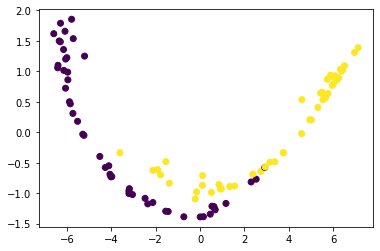

In [ ]:
def scatter_plot(x, labels):
    plt.scatter(x[::, 0], x[::, 1], c=labels)
    plt.show()

scatter_plot(principle_components, y.numpy())